In [1]:
!pip install datasets sentencepiece

     |████████████████████████████████| 432 kB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 140 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 24.0 MB 367 kB/s eta 0:00:01     |██████████████████              | 13.5 MB 9.2 MB/s eta 0:00:02
     |████████████████████████████████| 359 kB 13.1 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 60 kB 7.1 MB/s  eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.9.0
    Uninstalling fsspec-0.9.0:
      Successfully uninstalled fsspec-0.9.0


In [2]:
import json

f = open('data/poemonly_subsentence_translate_md_an.json')
data = json.load(f)


In [3]:
#data

In [4]:
from datasets import load_dataset
pos_dataset = load_dataset('json', data_files = 'data/poemonly_subsentence_translate_md_an.json')
pos_dataset

Using custom data configuration default-80211109369f19eb


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /Users/cosmonana/.cache/huggingface/datasets/json/default-80211109369f19eb/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 11542
    })
})

In [5]:
from sklearn.model_selection import train_test_split
pos_dataset_split = pos_dataset['train'].train_test_split(test_size = 0.2, seed=1234)

In [6]:
small = pos_dataset["train"].shuffle(seed=42).select(range(1_000))

In [7]:
split = small.train_test_split(seed=42)

In [8]:
split["train"][0]

{'id': 1396, 'translation': {'ancient': '罢归无旧业', 'modern': '后来他罢职回乡没有产业'}}

In [9]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/Users/cosmonana/opt/anaconda3/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [10]:
modern = split['train'][5]['translation']['modern']
ancient = split['train'][5]['translation']['ancient']
modern, ancient

('常常担心寒冷的露珠降临', '常恐零露降')

In [11]:
inputs = tokenizer(modern)
inputs

{'input_ids': [259, 182693, 154610, 35275, 16877, 493, 42215, 37944, 18293, 27341, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
targets = tokenizer(ancient)
targets

{'input_ids': [259, 13779, 42254, 40060, 42215, 18293, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [13]:
tokenizer.convert_ids_to_tokens(inputs['input_ids']), tokenizer.convert_ids_to_tokens(targets['input_ids'])

(['▁', '常常', '担心', '寒', '冷', '的', '露', '珠', '降', '临', '</s>'],
 ['▁', '常', '恐', '零', '露', '降', '</s>'])

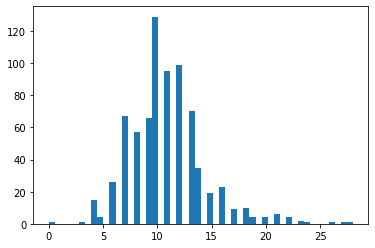

In [14]:
import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['modern']) for tr in train]

plt.hist(input_lens, bins=50); # in order to see the maximum length for truncation

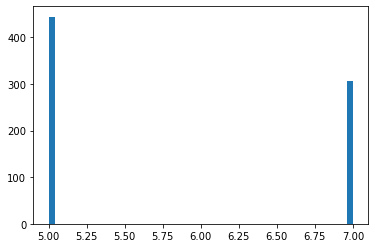

In [15]:
target_lens = [len(tr['ancient']) for tr in train]
plt.hist(target_lens, bins=50);

In [16]:
max_input_len = 32
max_target_len = 16

def tokenizer_fn(batch):
  inputs = [x['modern'] for x in batch['translation']]
  targets = [x['ancient'] for x in batch['translation']]

  tokenized_inputs = tokenizer(
    inputs, max_length=max_input_len, truncation=True)

  tokenized_targets = tokenizer(
    targets, max_length=max_target_len, truncation=True)
  
  tokenized_inputs['labels'] = tokenized_targets['input_ids']
  return tokenized_inputs

In [17]:
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True,
    remove_columns=split['train'].column_names,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [18]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 750
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 250
    })
})

In [19]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

In [20]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [21]:
tokenized_datasets["train"][1:3]

{'input_ids': [[259,
   133620,
   4989,
   5072,
   102703,
   3722,
   46917,
   106288,
   105301,
   201822,
   8369,
   1],
  [259, 5144, 6216, 11587, 8805, 9785, 1506, 2371, 84900, 39862, 2146, 1]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'labels': [[259, 5111, 36734, 2, 186746, 8230, 4398, 14735, 1],
  [259, 11364, 13746, 18910, 228437, 53476, 18910, 172597, 1]]}

In [22]:
[tokenized_datasets["train"][i] for i in range(1, 3)]

[{'input_ids': [259,
   133620,
   4989,
   5072,
   102703,
   3722,
   46917,
   106288,
   105301,
   201822,
   8369,
   1],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [259, 5111, 36734, 2, 186746, 8230, 4398, 14735, 1]},
 {'input_ids': [259,
   5144,
   6216,
   11587,
   8805,
   9785,
   1506,
   2371,
   84900,
   39862,
   2146,
   1],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [259, 11364, 13746, 18910, 228437, 53476, 18910, 172597, 1]}]

In [23]:
# batch = data_collator(tokenized_datasets["train"][1:3])
# batch.keys()

In [24]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys() 
# deta_collator needs the inputs to be a list of dict, each dict contains the info of a sample. so if we directly pass 
# tokenized_datasets["train"][1:3], as the previous 2 blocks shows, it won't fit the format.

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [25]:
batch["labels"]

tensor([[   259,   5111,  36734,      2, 186746,   8230,   4398,  14735,      1],
        [   259,  11364,  13746,  18910, 228437,  53476,  18910, 172597,      1]])

In [26]:
# think of seq2seq RNNs - the decoder RNN must have "some" input
# it's just like a language model where we predict the next word from
# previous words!
batch["decoder_input_ids"]

tensor([[     0,    259,   5111,  36734,      2, 186746,   8230,   4398,  14735],
        [     0,    259,  11364,  13746,  18910, 228437,  53476,  18910, 172597]])

In [27]:
# the first token is a pad!
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>', '▁', '同', '穴', '<unk>', '冥', '何', '所', '望']

In [28]:
# the labels are one step ahead - just like a language model
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁', '同', '穴', '<unk>', '冥', '何', '所', '望', '</s>']

In [29]:
split['train'][1]

{'id': 9332, 'translation': {'ancient': '同穴窅冥何所望', 'modern': '即使能合葬也无法倾诉衷情'}}

In [30]:
!pip install sacrebleu bert-score

     |████████████████████████████████| 116 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 8.0 MB/s  eta 0:00:01


In [31]:
from datasets import load_metric

bleu_metric = evaluate.load("sacrebleu")
bert_metric = evaluate.load("bertscore")

<ipython-input-31-ec0ba0363219>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [32]:
# targets must be in a list - as you recall, for bleu there can be multiple
# acceptable reference translations
bleu_metric.compute(predictions=["我爱猫"], references=[["我爱猫"]])

{'score': 0.0,
 'counts': [1, 0, 0, 0],
 'totals': [1, 0, 0, 0],
 'precisions': [100.0, 0.0, 0.0, 0.0],
 'bp': 1.0,
 'sys_len': 1,
 'ref_len': 1}

In [33]:
s = "我非常的喜欢猫猫和狗狗"
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 0.0,
 'counts': [1, 0, 0, 0],
 'totals': [1, 0, 0, 0],
 'precisions': [100.0, 0.0, 0.0, 0.0],
 'bp': 1.0,
 'sys_len': 1,
 'ref_len': 1}

In [34]:
bert_metric.compute(
    predictions=["我爱猫"], references=[["我喜欢猫"]], lang='zh') # need to specify language for bert score

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

{'precision': [0.8474210500717163],
 'recall': [0.81083083152771],
 'f1': [0.8287222981452942],
 'hashcode': 'bert-base-chinese_L8_no-idf_version=0.3.11(hug_trans=4.22.2)'}

In [35]:
import numpy as np

def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # for any -100 label, replace with pad token id
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='zh')

  return {'bert_score': np.mean(bert_score['f1'])}

In [36]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  "finetuned-model",
  evaluation_strategy="no",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=3,
  predict_with_generate=True,
  fp16=False,
)

In [37]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [38]:
# let's check our metrics before we start!
trainer.evaluate(max_length=max_target_len)

***** Running Evaluation *****
  Num examples = 250
  Batch size = 64


TypeError: 'list' object cannot be interpreted as an integer

In [39]:
# may run out of gpu memory - try to restart runtime
# or get a more powerful gpu!
trainer.train()

/Users/cosmonana/opt/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 750
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss


Saving model checkpoint to finetuned-model/checkpoint-24
Configuration saved in finetuned-model/checkpoint-24/config.json
Model weights saved in finetuned-model/checkpoint-24/pytorch_model.bin
tokenizer config file saved in finetuned-model/checkpoint-24/tokenizer_config.json
Special tokens file saved in finetuned-model/checkpoint-24/special_tokens_map.json
Copy vocab file to finetuned-model/checkpoint-24/spiece.model
Saving model checkpoint to finetuned-model/checkpoint-48
Configuration saved in finetuned-model/checkpoint-48/config.json
Model weights saved in finetuned-model/checkpoint-48/pytorch_model.bin
tokenizer config file saved in finetuned-model/checkpoint-48/tokenizer_config.json
Special tokens file saved in finetuned-model/checkpoint-48/special_tokens_map.json
Copy vocab file to finetuned-model/checkpoint-48/spiece.model
Saving model checkpoint to finetuned-model/checkpoint-72
Configuration saved in finetuned-model/checkpoint-72/config.json
Model weights saved in finetuned-mod

TrainOutput(global_step=72, training_loss=25.414442274305557, metrics={'train_runtime': 23942.2329, 'train_samples_per_second': 0.094, 'train_steps_per_second': 0.003, 'total_flos': 45164724572160.0, 'train_loss': 25.414442274305557, 'epoch': 3.0})

In [40]:
# let's check our metrics again
trainer.evaluate(max_length=max_target_len)

***** Running Evaluation *****
  Num examples = 250
  Batch size = 64


TypeError: 'list' object cannot be interpreted as an integer

In [41]:
trainer.save_model("my_saved_model")

Saving model checkpoint to my_saved_model
Configuration saved in my_saved_model/config.json
Model weights saved in my_saved_model/pytorch_model.bin
tokenizer config file saved in my_saved_model/tokenizer_config.json
Special tokens file saved in my_saved_model/special_tokens_map.json
Copy vocab file to my_saved_model/spiece.model


In [42]:
from transformers import pipeline
translator = pipeline("translation", model='my_saved_model', device=0)

loading configuration file my_saved_model/config.json
Model config MT5Config {
  "_name_or_path": "my_saved_model",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.22.2",
  "use_cache": true,
  "vocab_size": 250112
}

loading configuration file my_saved_model/config.json
Model config MT5Config {
  "_name_or_path": "my_saved_model",
  "architectures": [
    "MT5ForCon

AssertionError: Torch not compiled with CUDA enabled

In [43]:
translator("窗外的柳树已经发芽")

NameError: name 'translator' is not defined